In [1]:
import pvlib 
import pandas as pd
import matplotlib.pyplot as plt



In [2]:

# latitudes, longitude, name, altitude, timezone
coordinates = [(32.2, -111.0, 'Tucson', 700, 'Etc/GMT+7'),
               (35.1, -106.6, 'Albuquerque', 1500, 'Etc/GMT+7'),
              (37.8, -122.4, 'San Francisco', 10, 'Etc/GMT+8'),
              (52.5, 13.4, 'Berlin', 34, 'Etc/GMT-1'),]

In [8]:
#get the module and inverter specifications from SAM

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']


In [9]:
##retrieving meteorological data for the simulation, using iotools

tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location 
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude, map_variables = True)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)

In [13]:
## procedural 

system = {'module': module, 'inverter': inverter, 'surface_azimuth': 180}

energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location 
    system['surface_tilt'] = latitude
    solpos = pvlib.solarposition.get_solarposition(
    time = weather.index,
    latitude = latitude,
    longitude = longitude,
    altitude = altitude,
    temperature = weather["temp_air"],
    pressure = pvlib.atmosphere.alt2pres(altitude),
    )
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
    system['surface_tilt'],
    system['surface_azimuth'],
    solpos["apparent_zenith"],
    solpos["azimuth"],
    )
    
    total_irradiance = pvlib.irradiance.get_total_irradiance(
    system['surface_tilt'],
    system['surface_azimuth'],
    solpos['apparent_zenith'],
    solpos['azimuth'],
    weather['dni'],
    weather['ghi'],
    weather['dhi'],
    dni_extra = dni_extra,
    model='haydavies',
    )
    
    cell_temperature = pvlib.temperature.sapm_cell(
    total_irradiance['poa_global'],
    weather["temp_air"],
    weather["wind_speed"],
    **temperature_model_parameters,
    )
    
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    total_irradiance['poa_direct'],
    total_irradiance['poa_diffuse'],
    am_abs,
    aoi,
    module,
    )
    
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    annual_energy = ac.sum()
    energies[name] = annual_energy
    
    

In [14]:
energies = pd.Series(energies)


In [15]:
print(energies)

Tucson           435945.966478
Albuquerque      449905.549470
San Francisco    393749.297943
Berlin           243230.744245
dtype: float64


Text(0, 0.5, 'Yearly energy yield (W hr)')

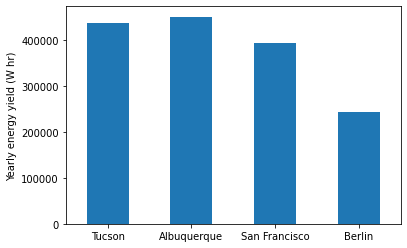

In [17]:
energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')
